In [11]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

In [12]:
#Read the data
df = pd.read_csv("df_full_premierleague.csv")

## Data Exploration and Data Visualization

In [13]:
df.shape

(4070, 114)

In [14]:
df.isnull().sum()[40:100] 
# It is because the first home and away match doesn't have value
# these features are "accumulated" 

fouls_conceded_avg_H        220
offsides_avg_H              220
passes_avg_H                220
possession_avg_H            220
red_cards_avg_H             220
shots_avg_H                 220
shots_on_target_avg_H       220
tackles_avg_H               220
touches_avg_H               220
yellow_cards_avg_H          220
goals_scored_ft_avg_H       220
goals_conced_ft_avg_H       220
sg_match_ft_acum_H          220
goals_scored_ht_avg_H       220
goals_conced_ht_avg_H       220
sg_match_ht_acum_H          220
performance_acum_H          220
clearances_avg_A            220
corners_avg_A               220
fouls_conceded_avg_A        220
offsides_avg_A              220
passes_avg_A                220
possession_avg_A            220
red_cards_avg_A             220
shots_avg_A                 220
shots_on_target_avg_A       220
tackles_avg_A               220
touches_avg_A               220
yellow_cards_avg_A          220
goals_scored_ft_avg_A       220
goals_conced_ft_avg_A       220
sg_match

In [15]:
df['Home_goals'] = df['result_full'].str.split('-').str[0].astype(int)
df['Away_goals'] = df['result_full'].str.split('-').str[1].astype(int)
df.Winner = ""
df.loc[df['Home_goals'] > df['Away_goals'], 'Winner'] = "home"
df.loc[df['Home_goals'] < df['Away_goals'], 'Winner'] = "away"
df.loc[df['Home_goals'] == df['Away_goals'], 'Winner'] = "draw"

df.Winner_home = 0
df.loc[df['Home_goals'] > df['Away_goals'], 'Winner_home'] = 1
df.loc[df['Home_goals'] < df['Away_goals'], 'Winner_home'] = 0
df.loc[df['Home_goals'] == df['Away_goals'], 'Winner_home'] = 0
df.Winner_away = 0
df.loc[df['Home_goals'] > df['Away_goals'], 'Winner_away'] = 0
df.loc[df['Home_goals'] < df['Away_goals'], 'Winner_away'] = 1
df.loc[df['Home_goals'] == df['Away_goals'], 'Winner_away'] = 0

df.Points_home = 0
df.loc[df['Home_goals'] > df['Away_goals'], 'Points_home'] = 3
df.loc[df['Home_goals'] < df['Away_goals'], 'Points_home'] = 0
df.loc[df['Home_goals'] == df['Away_goals'], 'Points_home'] = 1
df.Points_away = 0
df.loc[df['Home_goals'] > df['Away_goals'], 'Points_away'] = 0
df.loc[df['Home_goals'] < df['Away_goals'], 'Points_away'] = 3
df.loc[df['Home_goals'] == df['Away_goals'], 'Points_away'] = 1

<AxesSubplot:ylabel='Winner'>

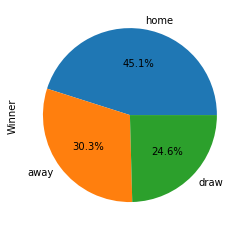

In [16]:
winners = df['Winner'].value_counts()
winners.plot.pie(autopct="%.1f%%")

<AxesSubplot:>

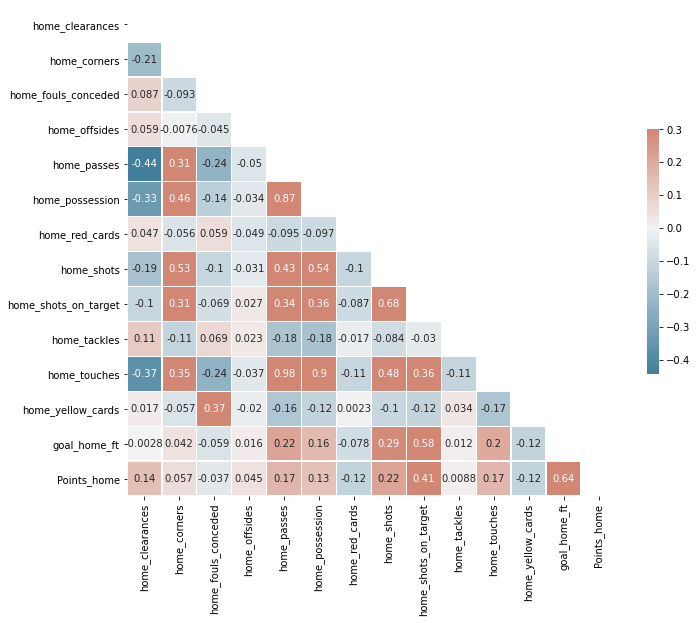

In [17]:
# based on https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = df[['home_clearances', 'home_corners', 'home_fouls_conceded',
           'home_offsides', 'home_passes', 'home_possession', 'home_red_cards',
           'home_shots', 'home_shots_on_target', 'home_tackles', 'home_touches',
           'home_yellow_cards','goal_home_ft', 'Points_home']] .corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<AxesSubplot:>

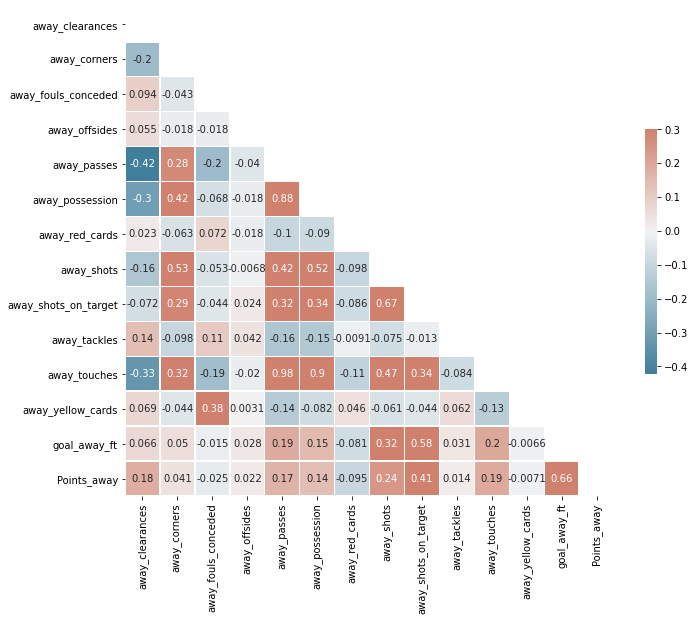

In [18]:
corr = df[['away_clearances', 'away_corners', 'away_fouls_conceded',
           'away_offsides', 'away_passes', 'away_possession', 'away_red_cards',
           'away_shots', 'away_shots_on_target', 'away_tackles', 'away_touches',
           'away_yellow_cards','goal_away_ft', 'Points_away']] .corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


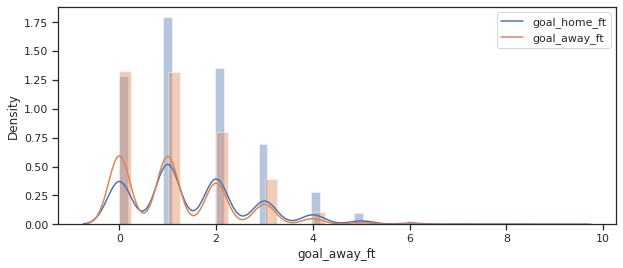

In [19]:
sns.set(style="ticks")
f, ax_hist = plt.subplots(figsize=(10,4))
sns.distplot(df['goal_home_ft'], ax=ax_hist)
sns.distplot(df['goal_away_ft'], ax=ax_hist)
plt.legend(loc='upper right', labels=['goal_home_ft', 'goal_away_ft'])

In [20]:
df.groupby('home_team')['Points_home'].sum().nlargest(5)

home_team
Manchester City      504.0
Manchester United    440.0
Chelsea              435.0
Arsenal              431.0
Liverpool            428.0
Name: Points_home, dtype: float64

In [21]:
df.groupby('away_team')['Points_away'].sum().nlargest(5)

away_team
Manchester City      387.0
Manchester United    354.0
Chelsea              342.0
Liverpool            336.0
Tottenham Hotspur    325.0
Name: Points_away, dtype: float64

In [22]:
df.groupby('away_team')['Points_away'].sum()/(df.groupby('away_team')['Points_away'].count()*3)

away_team
AFC Bournemouth             0.297872
Arsenal                     0.501634
Aston Villa                 0.297052
Birmingham City             0.228070
Blackburn Rovers            0.236842
Blackpool                   0.333333
Bolton Wanderers            0.271930
Brighton and Hove Albion    0.280952
Burnley                     0.320988
Cardiff City                0.210526
Chelsea                     0.558824
Crystal Palace              0.390411
Everton                     0.389163
Fulham                      0.272171
Huddersfield Town           0.184211
Hull City                   0.192982
Leeds United                0.461538
Leicester City              0.434109
Liverpool                   0.551724
Manchester City             0.635468
Manchester United           0.575610
Middlesbrough               0.175439
Newcastle United            0.306306
Norwich City                0.207018
Queens Park Rangers         0.169591
Reading                     0.140351
Sheffield United            

In [23]:
df.groupby('home_team')['Points_home'].sum()/(df.groupby('home_team')['Points_home'].count()*3)

home_team
AFC Bournemouth             0.445614
Arsenal                     0.707718
Aston Villa                 0.377011
Birmingham City             0.456140
Blackburn Rovers            0.412281
Blackpool                   0.350877
Bolton Wanderers            0.447368
Brighton and Hove Albion    0.394366
Burnley                     0.445455
Cardiff City                0.350877
Chelsea                     0.714286
Crystal Palace              0.397260
Everton                     0.592775
Fulham                      0.425076
Huddersfield Town           0.280702
Hull City                   0.426901
Leeds United                0.435897
Leicester City              0.556430
Liverpool                   0.699346
Manchester City             0.819512
Manchester United           0.722496
Middlesbrough               0.315789
Newcastle United            0.483696
Norwich City                0.421053
Queens Park Rangers         0.368421
Reading                     0.350877
Sheffield United            

In [24]:
df_2 = df[df['clearances_avg_H'].notnull()&df['clearances_avg_A'].notnull()]

## Modeling

In [25]:
# Features selected after the exploration
X = df_2[['clearances_avg_H', 'corners_avg_H', 'passes_avg_H', 'possession_avg_H', 'red_cards_avg_H',  'shots_on_target_avg_H', 
          'goals_scored_ft_avg_H', 'goals_conced_ft_avg_H', 'sg_match_ft_acum_H', 'goals_scored_ht_avg_H',
          'goals_conced_ht_avg_H', 'sg_match_ht_acum_H', 'performance_acum_H',
          'clearances_avg_A', 'corners_avg_A', 'passes_avg_A', 'possession_avg_A', 'red_cards_avg_A',  'shots_on_target_avg_A', 
          'goals_scored_ft_avg_A', 'goals_conced_ft_avg_A', 'sg_match_ft_acum_A', 'goals_scored_ht_avg_A',
          'goals_conced_ht_avg_A', 'sg_match_ht_acum_A', 'performance_acum_A']]
y = df_2['Points_home'].astype(int)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
# Material from course
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # your code here
    Y = pd.DataFrame(y)
    X = pd.DataFrame(x)
    df = pd.concat([Y, X], axis=1).dropna()
    name = data_dir+"/"+filename
    df.to_csv(name,index=False) #header=False, 
    
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [28]:
data_dir = 'premierleague_data'

make_csv(X_train, y_train, filename='train.csv', data_dir=data_dir)
make_csv(X_test, y_test, filename='test.csv', data_dir=data_dir)

Path created: premierleague_data/train.csv
Path created: premierleague_data/test.csv


In [29]:
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.boto_session.region_name

# create an S3 bucket
bucket = session.default_bucket()

In [32]:
! python script.py --n-estimators 1000 \
                   --min-samples-leaf 20 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   --features "clearances_avg_H corners_avg_H passes_avg_H possession_avg_H red_cards_avg_H shots_on_target_avg_H goals_scored_ft_avg_H goals_conced_ft_avg_H sg_match_ft_acum_H goals_scored_ht_avg_H goals_conced_ht_avg_H sg_match_ht_acum_H performance_acum_H clearances_avg_A corners_avg_A passes_avg_A possession_avg_A red_cards_avg_A shots_on_target_avg_A goals_scored_ft_avg_A goals_conced_ft_avg_A sg_match_ft_acum_A goals_scored_ht_avg_A goals_conced_ht_avg_A sg_match_ht_acum_A performance_acum_A" \
                   --target Points_home

extracting arguments
reading data
building training and testing datasets
training model
Accuracy is: 0.5212933753943217
model persisted at ./model.joblib
20


In [33]:
#based on: https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_randomforest/Sklearn_on_SageMaker_end2end.ipynb
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 1000,
        "min-samples-leaf": 10,
        "features": "clearances_avg_H corners_avg_H passes_avg_H possession_avg_H red_cards_avg_H shots_on_target_avg_H goals_scored_ft_avg_H goals_conced_ft_avg_H sg_match_ft_acum_H goals_scored_ht_avg_H goals_conced_ht_avg_H sg_match_ht_acum_H performance_acum_H clearances_avg_A corners_avg_A passes_avg_A possession_avg_A red_cards_avg_A shots_on_target_avg_A goals_scored_ft_avg_A goals_conced_ft_avg_A sg_match_ft_acum_A goals_scored_ht_avg_A goals_conced_ht_avg_A sg_match_ht_acum_A performance_acum_A",
        "target": "Points_home",
    },
)

In [34]:
data_dir = 'premierleague_data'
prefix = 'premierleague'
train_data_s3_path = session.upload_data(path=data_dir, key_prefix=prefix)
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix,train_data_s3_path+"/train.csv" ), content_type='csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix,train_data_s3_path+"/test.csv" ), content_type='csv')

In [35]:
sklearn_estimator.fit({"train": s3_input_train, "test": s3_input_test}, wait=False)

#### Tuning hyperparameters

In [36]:
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "n-estimators": IntegerParameter(20, 1500),
    "min-samples-leaf": IntegerParameter(2, 30),
}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name="RF-tuner",
    objective_type="Maximize",
    objective_metric_name="Accuracy",
    metric_definitions=[
        {"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"}
    ],  # extract tracked metric from logs with regexp
    max_jobs=20,
    max_parallel_jobs=2,
)

In [37]:
Optimizer.fit({"train": s3_input_train, "test": s3_input_test})

...............................................................

KeyboardInterrupt: 

In [ ]:
results = Optimizer.analytics().dataframe()
while results.empty:
    time.sleep(1)
    results = Optimizer.analytics().dataframe()
results.head()

In [ ]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

In [ ]:
model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [ ]:
predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)

In [ ]:
print(predictor.predict(testX[data.feature_names]))

In [ ]:
# uncomment and fill in the line below!
predictor.delete_endpoint()

In [ ]:
# deleting bucket, uncomment lines below
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()